In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/zillow-prize-1/sample_submission.csv
/kaggle/input/zillow-prize-1/train_2016_v2.csv
/kaggle/input/zillow-prize-1/properties_2016.csv
/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx
/kaggle/input/zillow-prize-1/properties_2017.csv
/kaggle/input/zillow-prize-1/train_2017.csv


In [2]:
%matplotlib inline
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

#sets up pandas table display
pd.set_option('display.width', 800)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
#stop scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Making a list of missing value types
missing_values = ["n/a", "na", "--"]

In [4]:
#load the 2016 properties data and target variable
house_2016_df = pd.read_csv('../input/zillow-prize-1/properties_2016.csv', na_values = missing_values, low_memory=False)
house_2017_df = pd.read_csv('../input/zillow-prize-1/properties_2017.csv', na_values = missing_values, low_memory=False)
house_log_2016 = pd.read_csv('../input/zillow-prize-1/train_2016_v2.csv', low_memory=False)
house_log_2017 = pd.read_csv('../input/zillow-prize-1/train_2017.csv', low_memory=False)

In [5]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

zillow-prize-1



In [6]:
print(house_2016_df.shape)
print(house_2017_df.shape)
print(house_log_2016.shape)
print(house_log_2017.shape)

(2985217, 58)
(2985217, 58)
(90275, 3)
(77613, 3)


In [7]:
#merge the trasaction dataset fro 2016-2017
#I drop the overlapped parcelid id 
house_log_full = pd.concat([house_log_2016,house_log_2017],ignore_index=True)
house_log_full2= house_log_full.drop_duplicates(subset= 'parcelid' )

In [8]:
#check if 2016 and 2017 is overlap 
len(set(house_2016_df['parcelid']).intersection(house_2017_df['parcelid']))

2985217

In [9]:
#so why use both year to join in 2017 house? 
#there are overlaps of parcelid id, 167888-165210= 2678

house_2017_full = house_2017_df.merge(house_log_full2, on = 'parcelid')

In [10]:
house_2017_full.shape

(165210, 60)

In [11]:
#house_2017_full has all th data that has log, so we need to find the test set 
#house_2017_full_2 = house_2017_df.merge(house_log_full, on = 'parcelid', how = "left")

In [12]:
#two method: 1 use the house_2017_full as the predict set, 2 use the unused as the predict set. 
#house_2017_full.shape

In [13]:
#house_2017_full_2[house_2017_full_2['logerror'].isnull()].shape

In [14]:
#submission= pd.read_csv("../input/zillow-prize-1/sample_submission.csv")

In [15]:
#submission.shape

In [16]:
#house_2017_full[house_2017_full['parcelid']==13850164]

In [17]:
#So there is a process of impute the boolean variables, but we didn't do that for the house_2017_full 
#impute boolean variables 
house_2017_full['fireplaceflag'].replace(True, 1, inplace=True)
house_2017_full['fireplaceflag'].fillna(0, inplace = True)
house_2017_full['hashottuborspa'].replace(True, 1, inplace=True)
house_2017_full['hashottuborspa'].fillna(0, inplace = True) 
house_2017_full['pooltypeid10'].fillna(0, inplace = True) 
house_2017_full['pooltypeid2'].fillna(0, inplace = True)
house_2017_full['pooltypeid7'].fillna(0, inplace = True)

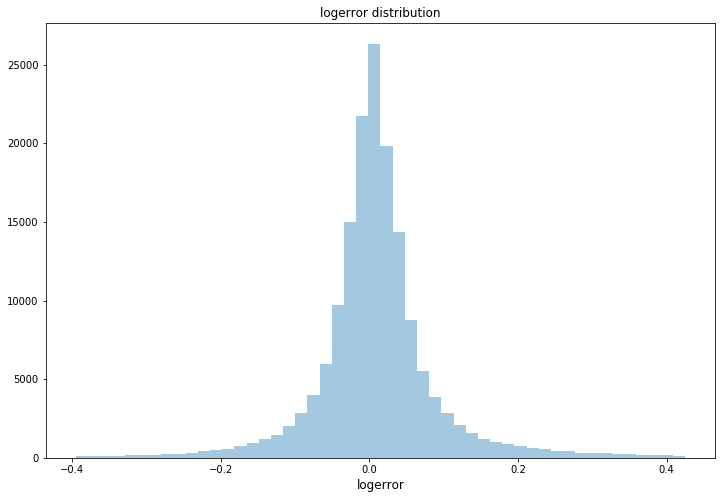

In [18]:
#plot distribution of target variable log error
#1.9% outliner. 
from scipy.stats import zscore
house_2017_full["logerror_zscore"] = zscore(house_2017_full["logerror"])
house_2017_full["is_outlier"] = house_2017_full["logerror_zscore"].apply(
  lambda x: x <= -2.5 or x >= 2.5
)

plt.figure(figsize=(12,8))
sb.distplot(house_2017_full[~house_2017_full['is_outlier']].logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.title('logerror distribution')
plt.show()    

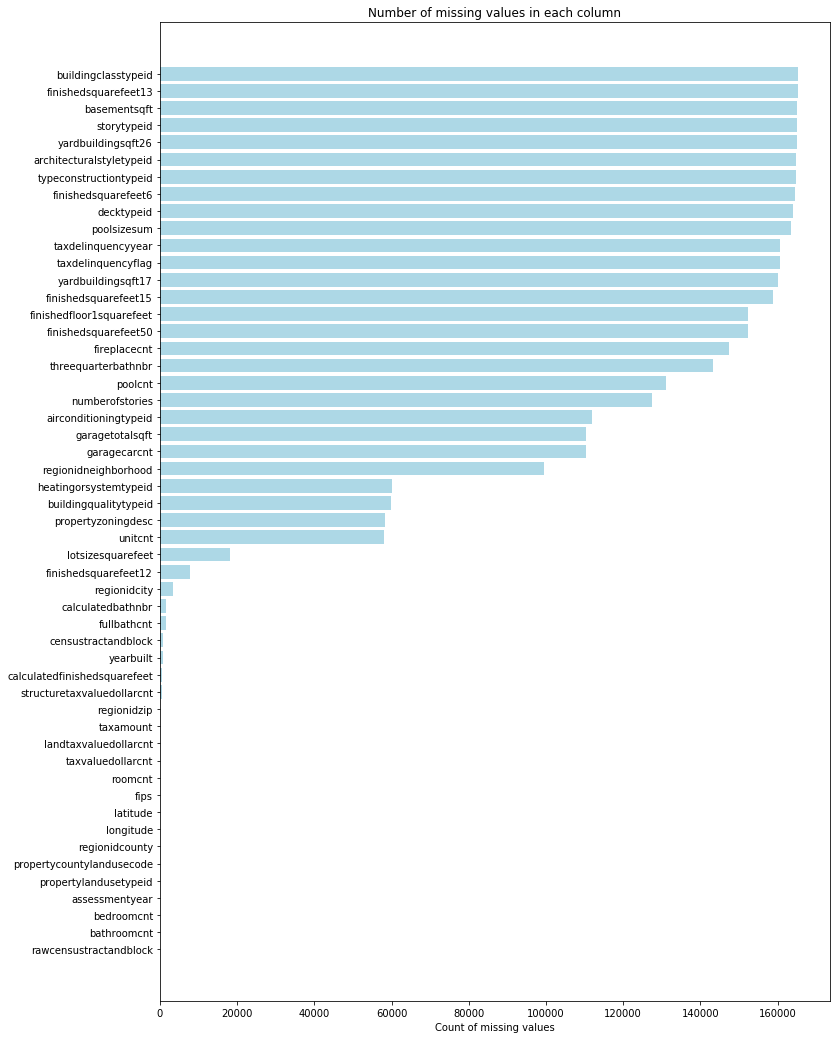

In [19]:
#explore the missing value
missing_df = house_2017_full.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='lightblue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show() 

In [20]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1~deb9u1-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmple_yovbq
  JVM stdout: /tmp/tmple_yovbq/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmple_yovbq/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 14 days
H2O cluster name:,H2O_from_python_unknownUser_laasq1
H2O cluster total nodes:,1
H2O cluster free memory:,2.889 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [21]:
house_2017_temp = house_2017_full[~house_2017_full['is_outlier']]
house_2017_tree = house_2017_temp.drop(['logerror_zscore','is_outlier','parcelid'], axis =1)
house_2017_full_hf = h2o.H2OFrame(house_2017_tree)
house_2017_tree.head(5)

#house_2017_tree dropped the outlier, the parcelid id and logerror_zscore

Parse progress: |█████████████████████████████████████████████████████████| 100%


,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,nan,nan,nan,5.00,4.00,nan,nan,5.00,nan,1968.00,3760.00,3760.00,nan,nan,1968.00,nan,6111.00,4.00,5.00,3.00,784.00,0.00,nan,34449407.00,-119254052.00,42688.00,1.00,735.00,0.00,0.00,1.00,1110,261.00,NaN,61110009.01,13091.00,2061.00,nan,97099.00,11.00,nan,nan,nan,nan,nan,nan,1982.00,2.00,0.00,501928.00,872850.00,2016.00,370922.00,9673.46,NaN,nan,61110009011034.00,-0.01,2017-06-15
1,nan,nan,nan,2.00,3.00,nan,nan,2.00,66.00,1444.00,1444.00,1444.00,nan,nan,1444.00,nan,6111.00,nan,2.00,1.00,0.00,0.00,nan,34454169.00,-119237898.00,7108.00,nan,nan,0.00,0.00,0.00,1110,261.00,NaN,61110009.03,13091.00,2061.00,nan,97099.00,6.00,nan,nan,nan,nan,nan,nan,1951.00,1.00,0.00,130845.00,436157.00,2016.00,305312.00,5538.80,NaN,nan,61110009034011.00,0.07,2017-07-26
2,nan,nan,nan,1.50,3.00,nan,nan,1.50,66.00,1698.00,1698.00,1698.00,nan,nan,1698.00,nan,6111.00,1.00,1.00,0.00,0.00,0.00,nan,34365693.00,-119448392.00,2588.00,nan,nan,0.00,0.00,0.00,1110,261.00,NaN,61110012.06,34543.00,2061.00,nan,97081.00,6.00,nan,1.00,nan,nan,nan,nan,1979.00,1.00,0.00,193413.00,286606.00,2016.00,93193.00,2987.36,NaN,nan,61110012061086.00,0.07,2017-07-28
3,nan,nan,nan,2.50,3.00,nan,nan,2.50,nan,548.00,1264.00,1264.00,nan,nan,548.00,nan,6111.00,nan,2.00,2.00,0.00,0.00,nan,34303597.00,-119287236.00,1735.00,nan,nan,0.00,0.00,0.00,1128,265.00,NaN,61110022.00,34543.00,2061.00,nan,97081.00,5.00,nan,1.00,nan,nan,128.00,nan,1986.00,2.00,0.00,116841.00,194734.00,2016.00,77893.00,2037.32,NaN,nan,61110022003007.00,0.10,2016-01-27
4,nan,nan,nan,2.00,2.00,nan,nan,2.00,nan,986.00,986.00,986.00,nan,nan,986.00,nan,6111.00,1.00,2.00,1.00,0.00,0.00,nan,34305600.00,-119284000.00,nan,nan,nan,0.00,0.00,0.00,1129,266.00,NaN,61110022.00,34543.00,2061.00,nan,97081.00,4.00,nan,nan,nan,nan,55.00,nan,1989.00,1.00,0.00,90357.00,258888.00,2016.00,168531.00,2706.24,NaN,nan,61110022003001.00,0.31,2017-06-02


drf Model Build progress: |███████████████████████████████████████████████| 100%


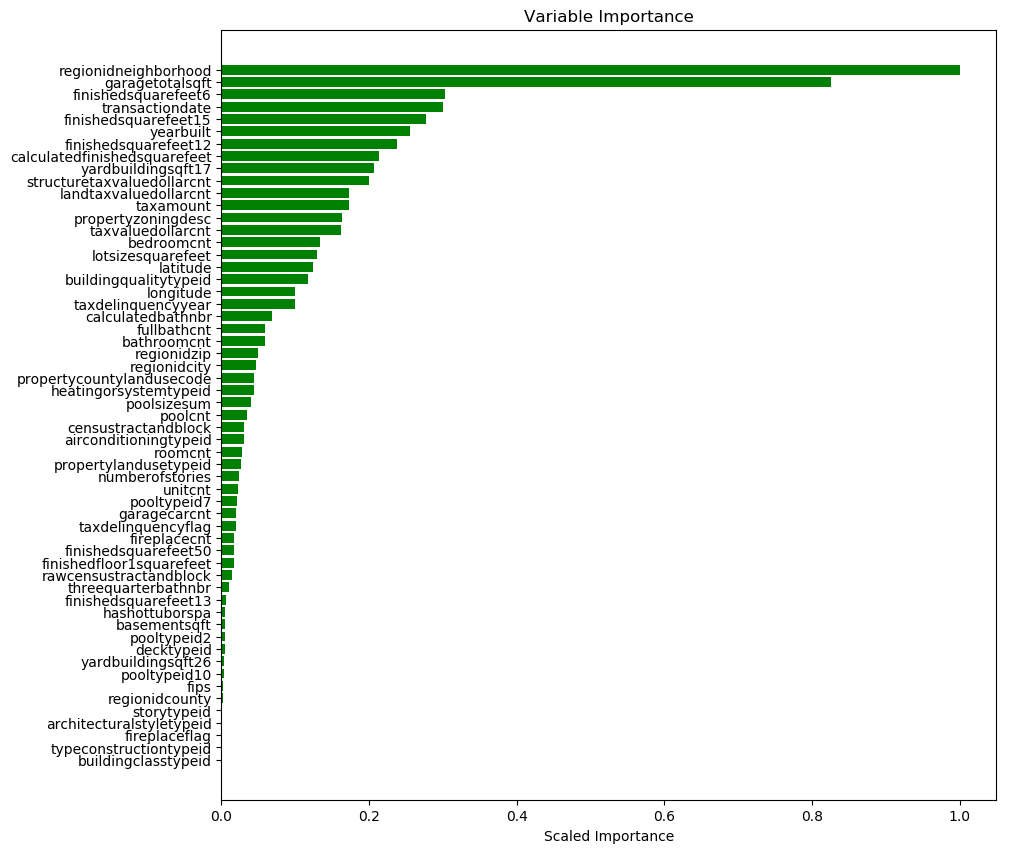

0             regionidneighborhood
1                  garagetotalsqft
2              finishedsquarefeet6
3                  transactiondate
4             finishedsquarefeet15
5                        yearbuilt
6             finishedsquarefeet12
7     calculatedfinishedsquarefeet
8               yardbuildingsqft17
9       structuretaxvaluedollarcnt
10           landtaxvaluedollarcnt
11                       taxamount
12              propertyzoningdesc
13               taxvaluedollarcnt
14                      bedroomcnt
15               lotsizesquarefeet
16                        latitude
17           buildingqualitytypeid
Name: variable, dtype: object

In [22]:
#defind the model
h2o_tree = H2ORandomForestEstimator(ntrees = 50, max_depth = 20, nfolds =10)
#train the model,if x not specify,model will use all x except the y column
h2o_tree.train(y = 'logerror', training_frame = house_2017_full_hf)
#print variable importance
h2o_tree_df = h2o_tree._model_json['output']['variable_importances'].as_data_frame()
#visualize the importance

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (10, 10))
variables = h2o_tree._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = h2o_tree._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

#choose features have importance score >0.2
feature_score = 0.1
selected_features = h2o_tree_df[h2o_tree_df.scaled_importance>=feature_score]['variable']
selected_features


In [23]:
selected_features = ['regionidneighborhood','taxamount','calculatedfinishedsquarefeet'
                     ,'yearbuilt','lotsizesquarefeet','propertyzoningdesc','garagetotalsqft','bedroomcnt','buildingqualitytypeid'
                     ,'calculatedbathnbr','yardbuildingsqft17']


In [24]:
selected_cols = (pd.Series(selected_features)).append(pd.Series(['logerror']))
#split data to training and test data set
X_train,X_test= train_test_split(house_2017_tree[selected_cols], test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)

(108495, 12)
(53438, 12)


In [25]:
len(X_train.columns)

12

In [26]:
X_test_pred= house_2017_df[selected_features]

In [27]:
X_test_pred.columns

Index(['regionidneighborhood', 'taxamount', 'calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet', 'propertyzoningdesc', 'garagetotalsqft', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yardbuildingsqft17'], dtype='object')

In [28]:
X_test_pred.shape

(2985217, 11)

In [29]:
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
X_test_pred_h2o = h2o.H2OFrame(X_test_pred)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
from h2o.estimators import H2OXGBoostEstimator

In [32]:
X_test_h2o.columns

['regionidneighborhood',
 'taxamount',
 'calculatedfinishedsquarefeet',
 'yearbuilt',
 'lotsizesquarefeet',
 'propertyzoningdesc',
 'garagetotalsqft',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'yardbuildingsqft17',
 'logerror']

In [33]:
"""
param = {
      "ntrees" : 100
    , "learn_rate" : 0.02
    , "max_depth" : 10
    , "sample_rate" : 0.7
    , "col_sample_rate_per_tree" : 0.9
    , "min_rows" : 5
    , "seed": 4241
    , "score_tree_interval": 100
    ,  'nfolds': 10
    , "stopping_metric" : "MSE"
}
from h2o.estimators import H2OXGBoostEstimator
model = H2OXGBoostEstimator(**param)
model.train(y = 'logerror', training_frame = X_train_h2o)
"""

'\nparam = {\n      "ntrees" : 100\n    , "learn_rate" : 0.02\n    , "max_depth" : 10\n    , "sample_rate" : 0.7\n    , "col_sample_rate_per_tree" : 0.9\n    , "min_rows" : 5\n    , "seed": 4241\n    , "score_tree_interval": 100\n    ,  \'nfolds\': 10\n    , "stopping_metric" : "MSE"\n}\nfrom h2o.estimators import H2OXGBoostEstimator\nmodel = H2OXGBoostEstimator(**param)\nmodel.train(y = \'logerror\', training_frame = X_train_h2o)\n'

In [34]:
#print(model.summary)

In [35]:
"""
hyper_params = {'max_depth' : [4,6,8,12,16,20]
               ,"learn_rate" : [0.1, 0.01, 0.0001] 
               }
param_grid = {
      "ntrees" : 50
    , "sample_rate" : 0.7
    , "col_sample_rate_per_tree" : 0.9
    , "min_rows" : 5
    , "seed": 4241
    , "score_tree_interval": 100
    ,  'nfolds': 10
    , "stopping_metric" : "MSE"
}
model_grid = H2OXGBoostEstimator(**param_grid)
"""

'\nhyper_params = {\'max_depth\' : [4,6,8,12,16,20]\n               ,"learn_rate" : [0.1, 0.01, 0.0001] \n               }\nparam_grid = {\n      "ntrees" : 50\n    , "sample_rate" : 0.7\n    , "col_sample_rate_per_tree" : 0.9\n    , "min_rows" : 5\n    , "seed": 4241\n    , "score_tree_interval": 100\n    ,  \'nfolds\': 10\n    , "stopping_metric" : "MSE"\n}\nmodel_grid = H2OXGBoostEstimator(**param_grid)\n'

In [36]:
"""
#grid = H2OGridSearch(model_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})


#Train grid search
#grid.train(y='logerror',
       #    training_frame = X_train_h2o)
       """

'\n#grid = H2OGridSearch(model_grid,hyper_params,\n                         grid_id = \'depth_grid\',\n                         search_criteria = {\'strategy\': "Cartesian"})\n\n\n#Train grid search\n#grid.train(y=\'logerror\',\n       #    training_frame = X_train_h2o)\n       '

In [37]:
#xgb_gridperf = grid.get_grid(sort_by='mse', decreasing=True)
#xgb_gridperf

In [38]:
best_param = {
      "ntrees" : 100
    , "learn_rate" : 0.1
    , "max_depth" : 6
    , "sample_rate" : 0.7
    , "col_sample_rate_per_tree" : 0.9
    , "min_rows" : 5
    , "seed": 4241
    , "score_tree_interval": 100
    ,  'nfolds': 10
    , "stopping_metric" : "MSE"
}

best_model = H2OXGBoostEstimator(**best_param)
best_model.train(y = 'logerror', training_frame = X_train_h2o)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [39]:
# create the test set metrics for the best model
best_metrics = best_model.model_performance(test_data=X_test_h2o) 
best_metrics


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 0.006716835408543648
RMSE: 0.08195630182324998
MAE: 0.05227382504021737
RMSLE: 0.08182649891975173
Mean Residual Deviance: 0.006716835408543648


In [40]:
result=best_model.predict(X_test_pred_h2o)

xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'propertyzoningdesc' has levels not trained on: [#12, **AHRP, 0100, 0101, 010E, 010V, 012C, 0200, 0300, 0700, 1, 16, 1DC*, 1DM*, 1KR1, 1NC2*, 1NC2YY, 1NP1*, 1NR2*, 1NR2YY, 1RA1*, 2 UNITS IN, 4BR1, 5DMFD*, 6CRA20000*, 770429134, 8513008051, 97, A-1, A1*, A11*, A2C2*, A2P*, AAR3*, AH BP-M-FC, AH BP-OR-F, AH BP-OR-O, AH CRS-FC-, AH OS*, AH RL 2000, AH RS(3)10, AH RS22000, AH11*, AHA17500*, AHAI*, AHC2*, AHCR*, AHOS-OA*, AHPRD10*, AHR1-7000*, AHR1-7OOO*, AHR115000*, AHR17500-C, AHR175OO*, AHR17OOO*, AHR325U*, AHRA 20000, AHRA*, AHRA20, AHRA20000, AHRM-CD-FC, AHRP, AHRPD1OOOO, AHRPD51V-R, AHRPD7OOO6, AHRS, AHRS*, AHRS-(3)10, AHRS5-7000, ALC4, ALCO*, ALCO-RPD*, ALCPD-RPD*, ALP-RPD*, ALR*, ALR1, ALR1 *, ALR1**, ALR16500*, ALR171/2, ALR175, ALR17500, ALR1Y*, ALR1YY*, ALR2*, ALR3, ALR3YY, ALR4*, ALRI*, ALRPD, ALRPD-R*, ALRPD-R1*, ALRPDP*, ALRPDR*, ALRPOX, APR1*, APR2*, AR1*, ARC-OD*, ARC0YY, ARC1VV

In [41]:
#h2o.h2o.download_csv(result, "Predcited.csv")

In [42]:
result_list = h2o.h2o.as_list(result)

In [43]:
len(result_list)

2985217

In [44]:
house_2017_df["logerror"]=result_list
Submit = house_2017_df[["parcelid","logerror"]]

In [45]:
Submit["201610"]=result_list
Submit["201611"]=result_list
Submit["201612"]=result_list
Submit["201710"]=result_list
Submit["201711"]=result_list
Submit["201712"]=result_list


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [46]:
Submit = Submit.drop("logerror",axis=1)


In [47]:
Submit.columns = ["ParcelId", "201610","201611","201612","201710","201711","201712"]


In [48]:
Submit.to_csv("Submission.csv", index = False )

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 